In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
# new import statements
from sklearn.cluster import KMeans

# Unsupervised Machine Learning: Clustering

- In classification (supervised), we try to find boundaries/rules to separate points according to pre-determined labels.
- In clustering, the algorithm chooses the labels.  Goal is to choose labels so that similar rows get labeled the same.

### K-Means Clustering

- K: number of clusters:
    - 3-Means => 3 clusters
    - 4-Means => 4 clusters, and so on
- Means: we will find centroids (aka means aka averages) to create clusters

#### Iterative algorithm for K-Means

Animation of the iterative K-Means algorithm: https://www.youtube.com/watch?v=5I3Ei69I40s

In [2]:
# Generate random data
x, y = datasets.make_blobs(n_samples=100, centers=3, cluster_std=1.2, random_state=3)
df = pd.DataFrame(x, columns=["x0", "x1"])
df.head()

,x0,x1
0,8.370099,7.747045
1,-2.701740,0.395336
2,-3.204128,-0.407438
3,-3.132762,-1.335692
4,7.152737,6.069995


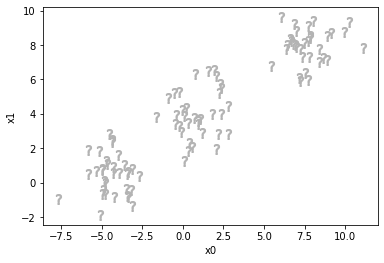

In [3]:
def km_scatter(df, **kwargs):
    """
    Produces scatter plot visualizations with x0 on x-axis and y0 on y-axis.
    It can also plot the centroids for clusters.
    Parameters:
        x0 => x-axis
        x1 => y-axis
        cluster => marker type
    """
    ax = kwargs.pop("ax", None)
    if not "label" in df.columns:
        return df.plot.scatter(x="x0", y="x1", marker="$?$", ax=ax, **kwargs)

    for marker in set(df["label"]):
        sub_df = df[df["label"] == marker]
        ax = sub_df.plot.scatter(x="x0", y="x1", marker=marker, ax=ax, **kwargs)
    return ax

ax = km_scatter(df, s=100, c="0.7")

### Hard Problem

Finding the best answer. What is the answer? Determing the centroids of the clusters.

### Easier Problem

Taking a random answer and make it a little better. Then repeat!
Downside? If randomization leads to very bad initial choice of centroids, that might lead to bad clustering (fewer clusters).

<AxesSubplot:xlabel='x0', ylabel='x1'>

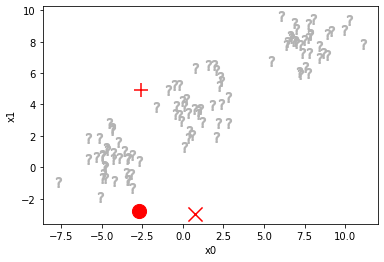

In [4]:
clusters = np.random.uniform(-5, 5, size=(3, 2))
clusters = pd.DataFrame(clusters, columns=["x0", "x1"])
clusters["label"] = ["o", "+", "x"]

ax = km_scatter(df, s=100, c="0.7")
km_scatter(clusters, s=200, c="red", ax=ax)

Two variables for us to deal with:
1. clusters: contains location of centroids and a label for them
2. df: contains the actual data points

In [5]:
clusters

,x0,x1,label
0,-2.687248,-2.806318,o
1,-2.577471,4.927183,+
2,0.758907,-2.977657,x


In [6]:
df.head()

,x0,x1
0,8.370099,7.747045
1,-2.701740,0.395336
2,-3.204128,-0.407438
3,-3.132762,-1.335692
4,7.152737,6.069995


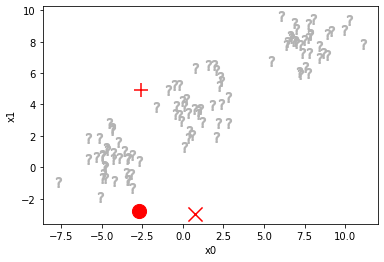

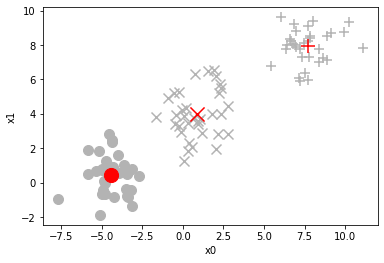

In [7]:
class KM:
    def __init__(self, df, clusters):
        # We make copies because we are going to keep changing the dataframe to 
        # identify better clusters
        self.df = df.copy()
        self.clusters = clusters.copy()
        self.labels = clusters["label"].values
        
    def plot(self):
        ax = km_scatter(self.df, color="0.7", s=100)
        km_scatter(self.clusters, ax=ax, color="red", s=200)
        
    def assign_points(self):
        """
        compute Euclidean distance between each point and each centroids
        """
        for center in self.clusters.itertuples():
            # Euclidean distance
            x0_diff = df["x0"] - center.x0
            x1_diff = df["x1"] - center.x1
            distances = (x0_diff ** 2 + x1_diff ** 2) ** 0.5
            # add distance to each centroid as a column within the dataframe
            self.df[center.label] = distances
        # get the label of the nearest centroid
        self.df["label"] = self.labels[self.df[self.labels].values.argmin(axis=1)]
    
    def update_centers(self):
        """
        update centroids by taking mean of the points that are nearest to that
        particular centroid
        """
        for center in self.clusters.itertuples():
            subset_df = self.df[self.df["label"] == center.label]
            if len(subset_df) > 0:
                x0 = subset_df["x0"].mean()
                x1 = subset_df["x1"].mean()
                self.clusters.at[center.Index, "x0"] = x0
                self.clusters.at[center.Index, "x1"] = x1

"""
High-level algorithm:
1. Start with random locations for centroids
2. Iterate over each data point:
    1. Find the distance (Euclidean distance) between current data point and each centroid.
    2. Find the minimum of those distances and the corresponding label.
    3. Assign current data point to the closest cluster centroid label.
4. Once all points are assigned, compute new centroid for each cluster. Iterate over 
   each cluster:
    1. Extract subset of data points which got assigned to curr cluster label.
    2. Compute mean of all the assigned data points.
    3. Update cluster centroid.
5. Repeat steps 2 to 4 many times (iterative improvement).
"""

# Creating object instance
km = KM(df, clusters)
km.plot()

for i in range(10):
    km.assign_points()
    km.update_centers()
    
km.plot()

### `sklearn KMeans`

- import statement:
```python
from sklearn.cluster import KMeans
```
- documentation: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

**Instantiation:**
`KMeans(n_clusters=<num>, n_init=<num>, max_iter=<num>)`
- `n_clusters`: number of clusters to be formed
- `n_init`: number of initial random seeds to try (to avoid downside of bad initial random choices)
- `max_iter`: maximum number of iterations for a single K-means run (single starting seed)

In [8]:
km_cluster = KMeans(3)
km_cluster

KMeans(n_clusters=3)

In [9]:
df.head()

,x0,x1
0,8.370099,7.747045
1,-2.701740,0.395336
2,-3.204128,-0.407438
3,-3.132762,-1.335692
4,7.152737,6.069995


**Methods:**
1. `fit`: find good centroids
2. `transform`: give me the distances from each point to each centroid
3. `predict`: give me the chosen group labels

**Attributes:**
- `<km object>.cluster_centers_`: coordinates of cluster centers
- `<km object>.inertia_`: sum of squared distances of samples to their closest cluster center

In [10]:
# `fit`: find good centroids
km_cluster.fit(df)
# coordinates of cluster centers
km_cluster.cluster_centers_

array([[ 0.85985598,  3.98556415],
       [ 7.69751168,  7.9241129 ],
       [-4.41347291,  0.43410278]])

**Observeration:** 3 rows (because we have 3 clusters), and 2 columns (because the df had 2 columns).

In [11]:
# `transform`: give me the distances from each point to each centroid
km_cluster.transform(df)

array([[ 8.39955315,  0.69550479, 14.72748598],
       [ 5.057144  , 12.83849367,  1.71217188],
       [ 5.984516  , 13.72080475,  1.47333179],
       [ 6.65257594, 14.24916908,  2.18458064],
       [ 6.62911793,  1.93249405, 12.86625407],
       [ 6.42867089, 14.14472291,  1.56004975],
       [ 7.00663718, 14.79157898,  1.29983259],
       [ 7.09747529,  1.56332001, 13.35025948],
       [ 6.1620119 , 13.93648735,  1.20010768],
       [ 1.75079801,  9.23940355,  5.12923462],
       [ 7.45185474, 15.29849451,  1.23053441],
       [ 8.98045036,  1.52459286, 15.3322184 ],
       [10.91386222,  3.37380113, 17.16390523],
       [ 8.05146158,  0.29966036, 14.40658807],
       [ 1.50499677,  6.61820665,  7.66113117],
       [ 5.52922108, 13.2665394 ,  2.37571603],
       [ 8.29635389,  0.53707918, 14.65282383],
       [ 7.93015965,  1.55598141, 14.25952349],
       [ 5.48003982, 13.29440299,  1.90656095],
       [ 7.2343239 , 15.0936722 ,  0.96395695],
       [ 1.41855649,  9.25115661,  4.992

**Observations**: Each row corresponds to a row in df. 3 columns correspond to 3 distances to the centroids.

In [12]:
# `predict`: give me the chosen group labels
km_cluster.predict(df)

array([1, 2, 2, 2, 1, 2, 2, 1, 2, 0, 2, 1, 1, 1, 0, 2, 1, 1, 2, 2, 0, 0,
       2, 0, 2, 1, 1, 0, 2, 1, 0, 0, 1, 2, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       2, 2, 0, 2, 1, 2, 0, 1, 2, 1, 2, 1, 2, 1, 0, 0, 0, 2, 0, 0, 2, 0,
       1, 2, 0, 2, 2, 1, 0, 2, 0, 0, 2, 0, 1, 2, 0, 0, 0, 0, 1, 0, 2, 1,
       0, 1, 0, 1, 1, 2, 1, 2, 2, 0, 1, 1], dtype=int32)

### How many clusters do we need?

- metric: `<km object>.inertia_`: sum of squared distances of samples to their closest cluster center

In [13]:
km_cluster.inertia_

260.7196850565892

**Observation**: we want "inertia" to be as small as possible.

### Elbow plot to determine `n_clusters`

In [14]:
s = pd.Series(dtype=float)

for num_clusters in range(1, 11):
    km = KMeans(num_clusters)
    km.fit(df)
    s.at[num_clusters] = km.inertia_
s

1     3621.095890
2      927.007644
3      260.719685
4      211.730031
5      181.995815
6      153.790312
7      130.505100
8      110.615199
9       93.692285
10      82.856078
dtype: float64

Text(0.5, 0, 'Number of clusters')

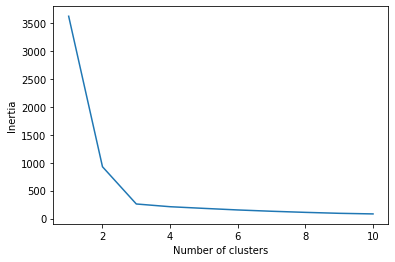

In [15]:
ax = s.plot.line(figsize=(6, 4))
ax.set_ylabel("Inertia")
ax.set_xlabel("Number of clusters")

**Observation**: there is an "elbow" around `n_clusters`=3.

#### Will we always have a clear "elbow"?

- Let's generate uniform random data

In [16]:
df2 = pd.DataFrame(np.random.uniform(0, 10, (100, 2)))
df2.head()

,0,1
0,1.942380,8.566563
1,2.810234,1.669021
2,9.231927,9.209231
3,0.365883,9.954519
4,7.500639,3.275227


<AxesSubplot:xlabel='0', ylabel='1'>

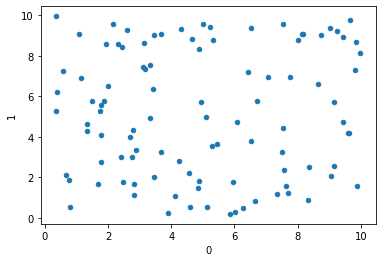

In [17]:
df2.plot.scatter(x=0, y=1)

Text(0.5, 0, 'Number of clusters')

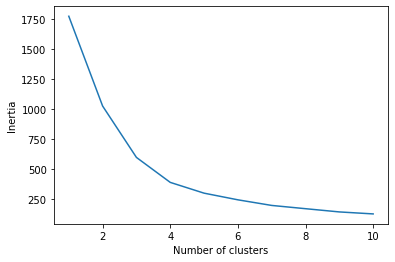

In [18]:
s = pd.Series(dtype=float)

for num_clusters in range(1, 11):
    km = KMeans(num_clusters)
    km.fit(df2)
    s.at[num_clusters] = km.inertia_

ax = s.plot.line(figsize=(6, 4))
ax.set_ylabel("Inertia")
ax.set_xlabel("Number of clusters")